# Some references

https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

In [1]:
%matplotlib inline
import sourmash_lib, sourmash_lib.fig

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
import hdbscan
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import palettable as pal
import pandas as pd

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


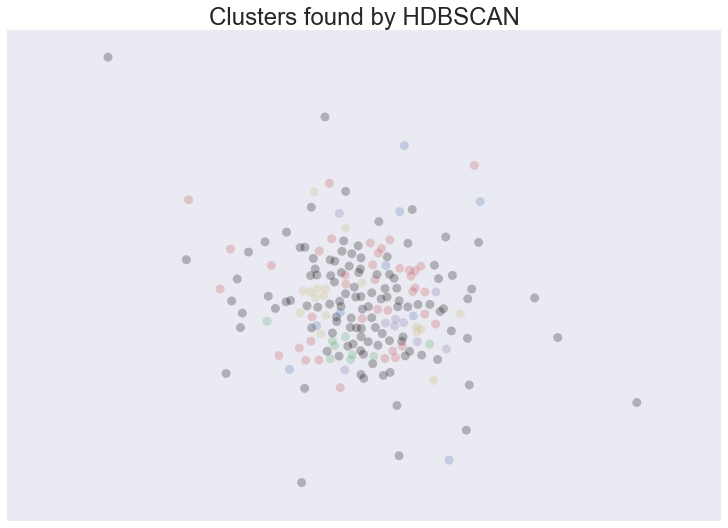

In [3]:
# cluster data using 'algorithm', then use TSNE to plot & color by clustesr
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #print(labels)
    end_time = time.time()
    
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    t = TSNE(n_components=2, perplexity=5).fit_transform(data)

    df = pd.DataFrame(t)
    df.columns=['t1','t2']
    df['colors'] = pd.Series(colors, index=df.index)

    plt.scatter(df.t1, df.t2, c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    return labels
   
# do a quick test run on a small subset
subs2, subs2_labels = sourmash_lib.fig.load_matrix_and_labels('subselect_2')
cluster_labels = plot_clusters(subs2[:200, :200], hdbscan.HDBSCAN, (), {'min_cluster_size':5})

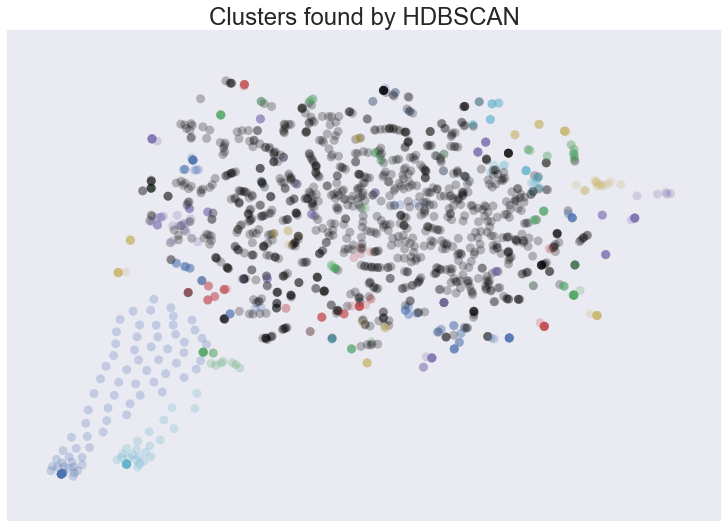

In [4]:
subs2, subs2_labels = sourmash_lib.fig.load_matrix_and_labels('subselect_2')
cluster_labels = plot_clusters(subs2, hdbscan.HDBSCAN, (), {'min_cluster_size':20})

In [5]:
# create a data frame that connects sample_index, cluster label, hash value, and cluster size
def make_sample_df(cluster_labels, sample_labels):
    df_cl = pd.DataFrame(cluster_labels)
    df_cl.index.name = 'sample_index'
    df_cl.columns = ['cluster']
    df_cl['hashval'] = pd.DataFrame(list(map(int, subs2_labels)))
    df_cl = df_cl[df_cl.cluster != -1]
    
    df_cl['cluster_size'] = df_cl.groupby('cluster')['cluster'].transform('count')

    return df_cl

# save the hashvals in a given sample df into a signature file.
def save_signature(filename, sample_df, name='', k=31, scaled=100000):
    x = sourmash_lib.MinHash(0, 31, scaled=100000)
    x.add_many(list(sample_df.hashval))

    s = sourmash_lib.SourmashSignature('', x, name=name)
    sourmash_lib.save_signatures([s], open(filename, 'wt'))

subs2_df = make_sample_df(cluster_labels, subs2_labels)

# Example: select out the two largest clusters and save as a signature.

In [6]:
SELECT_TOP_N=2

xx = list(sorted(set(subs2_df['cluster_size']), reverse=True))[:SELECT_TOP_N]
toptwo = subs2_df[subs2_df.cluster_size.isin(xx)]
save_signature('toptwo.sig', toptwo, name='toptwo')

# Example: TSNE plot just the clusters

In [7]:
t = TSNE(n_components=2).fit_transform(subs2)

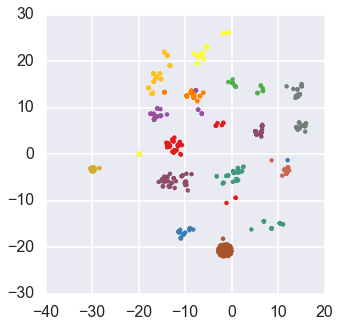

In [8]:
tsne_df=pd.DataFrame(t)
tsne_df.columns=['t1','t2']

subs2_tsne_df = subs2_df.join(tsne_df, how='inner')

fig,ax=plt.subplots(1)
fig.set_size_inches(5,5)
cmap=pal.colorbrewer.qualitative.Set1_7.get_mpl_colormap()

ax.scatter(subs2_tsne_df.t1, subs2_tsne_df.t2, c=subs2_tsne_df.cluster, cmap=cmap, lw=0)

#x = sourmash_lib.MinHash(0, 31, scaled=100000)
#x.add_many(map(int, tsne_df.hashvals))

#s = sourmash_lib.SourmashSignature('', x)
#sourmash_lib.save_signatures([s], open('all-clusters.sig', 'wt'))

# Example: select only the clusters out of the original matrix

In [9]:

subs2_clusters = subs2[np.ix_(subs2_df.index, subs2_df.index)]
subs2_clusters_labels = [str(x) for x in subs2_df.hashval]

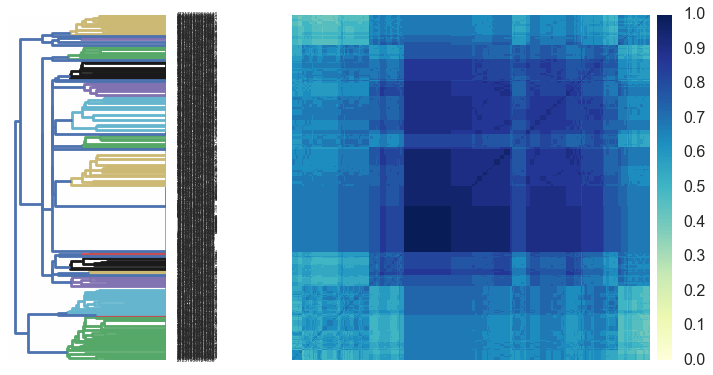

In [10]:
_ = sourmash_lib.fig.plot_composite_matrix(subs2_clusters, subs2_clusters_labels)